In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf
import tensorflowjs as tfjs
import os

%load_ext autotime


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM, Activation, Dense, Dropout, GRU,Conv1D,MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools

time: 157 ms


Using TensorFlow backend.


In [7]:
pd.set_option('display.max_columns', None)

time: 1 ms


In [8]:
# Deinfe integer encoding for the 6 classes:
activity_to_code = {'dws': 1, 'ups': 2, 'sit': 3, 'std': 4, 'wlk': 5, 'jog': 6}
code_to_activity = {v:k for k,v in activity_to_code.items()}

time: 1e+03 µs


In [9]:
code_to_activity = {v: k for k, v in activity_to_code.items()}

time: 1 ms


In [10]:
def load_raw_data(data_directory_path):
    """
    Given a path to the motionsense-dataset directory, loop through the different CSVs and concatenate them 
    to one pandas DataFrame. Join with demographic data, and return the DataFrame.
    """
    subjects_data_directory_path = os.path.join(dataset_path, "data_subjects_info.csv")
    
    # Load demographic data of subjects:
    subject_data = pd.read_csv(subjects_data_directory_path).rename(columns={'code':'subject'}) # rename for clarity
    subject_data['subject'] = subject_data.subject.astype(str)

    # Load data from sensor:
    motion_data_directory_path = os.path.join(dataset_path, r"A_DeviceMotion_data")
    dirs = os.listdir(motion_data_directory_path)
    dfs = []
    for d in dirs:
        activity_name, experiment_id = d.split("_")
        for subject in os.listdir(os.path.join(motion_data_directory_path, d)):
            filepath = os.path.join(os.path.join(motion_data_directory_path, d), subject)
            df = pd.read_csv(filepath, index_col=0)
            df['subject'] = subject.split(".")[0].split("_")[1] # keep only the subject's numerical i.d.
            df['activity'] = activity_to_code[activity_name]
            df['experiment_id'] = int(experiment_id)
            df['experiment_step'] =  np.arange(0, len(df)) # assign a numerical step number for every measurement in the experiment
            dfs.append(df)

    motion_data = pd.concat(dfs)
    
    # Join demographic data to final dataframe:
    final_df = motion_data.merge(subject_data, on=['subject'])
    
    return final_df, subject_data

time: 1 ms


In [11]:
dataset_path = r"../data" # Assuming here dataset is in cwd.
raw_df, subject_data = load_raw_data(dataset_path)

time: 7.16 s


In [61]:
MOTION_SENSOR_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 
                         'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
                        'userAcceleration.z']
DEMOGRAPHIC_FEATURES = ['weight', 'height', 'age', 'gender']

time: 3 ms


In [13]:
raw_df[MOTION_SENSOR_COLUMNS].describe(percentiles=[0.001,0.01,0.25,0.5,0.75,0.95,0.99, 0.999]).round(3)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
count,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000
mean,-0.176,-0.987,-0.149,0.042,0.755,-0.139,0.005,0.015,0.013,-0.004,0.044,0.039
std,1.567,0.494,1.545,0.339,0.333,0.428,1.293,1.226,0.808,0.328,0.528,0.376
min,-3.142,-1.570,-3.142,-1.000,-1.000,-1.000,-17.366,-18.414,-12.151,-6.369,-5.674,-7.743
0.1%,-3.129,-1.557,-3.132,-0.986,-0.997,-1.000,-5.761,-6.713,-4.501,-2.009,-2.137,-2.361
1%,-3.044,-1.533,-3.030,-0.782,-0.117,-0.998,-3.596,-3.624,-2.539,-1.050,-1.323,-1.111
25%,-1.480,-1.358,-1.278,-0.173,0.584,-0.392,-0.286,-0.167,-0.097,-0.048,-0.062,-0.024
50%,0.122,-1.181,-0.136,0.020,0.925,-0.097,-0.000,0.000,0.000,0.001,0.004,0.003
75%,0.876,-0.623,0.829,0.272,0.978,0.085,0.116,0.231,0.113,0.044,0.052,0.105
95%,2.372,-0.092,2.674,0.605,0.997,0.720,2.406,1.953,1.313,0.467,0.871,0.638


time: 610 ms


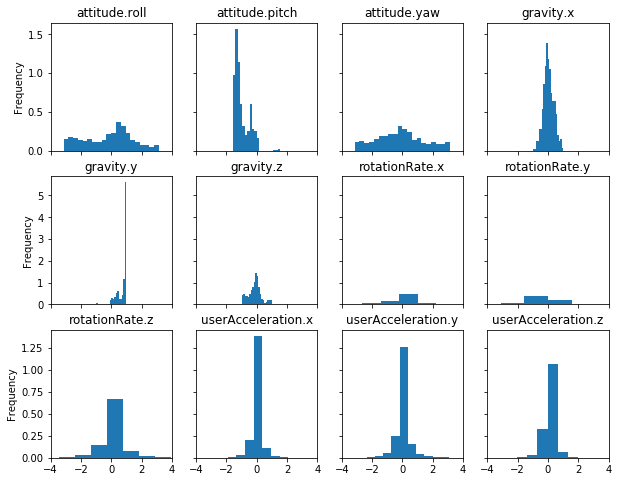

time: 2.21 s


In [14]:
samp = raw_df.sample(10**5) # plotting a sample, for run-time considerations
fig, ax = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(10, 8))

m=0
for i in range(3):
    for j in range(4):
        colname = MOTION_SENSOR_COLUMNS[m]
        samp[colname].plot(kind='hist', ax=ax[i,j], bins=20, title=colname, density=True, xlim=(-4,4))
        m += 1
plt.show()

In [15]:
raw_df[['weight','height','age']].describe().round(2)

,weight,height,age
count,1412865.00,1412865.00,1412865.00
mean,72.12,173.99,28.83
std,15.98,8.80,5.30
min,48.00,161.00,18.00
25%,60.00,164.00,25.00
50%,72.00,175.00,28.00
75%,78.00,180.00,31.00
max,102.00,190.00,46.00


time: 112 ms


In [16]:
raw_df.groupby(['subject', 'activity'])['userAcceleration.x'].count().reset_index()

,subject,activity,userAcceleration.x
0,1,1,5105
1,1,2,6336
2,1,3,20584
3,1,4,12747
4,1,5,11112
...,...,...,...
139,9,2,6492
140,9,3,16206
141,9,4,9829
142,9,5,14192


time: 108 ms


## Map activities

In [17]:
raw_df['activity_name'] = raw_df.activity.map(code_to_activity)

time: 41 ms


In [18]:
raw_df['activity_name'].unique()

array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype=object)

time: 35 ms


In [46]:
macro_activity = {'sit':'sedentary','std':'sedentary','wlk':'lm','dws':'lm','ups':'lm',
                     'jog':'vigorous'}

time: 1 ms


In [20]:
raw_df['macro_activity'] = raw_df.activity_name.map(macro_activity)

time: 92 ms


In [21]:
# create integer version in order to do 1-hot encoding
raw_df['pa_label']=raw_df.macro_activity.map({'sedentary':0,'lm':1,'vigorous':2})

time: 57 ms


In [22]:
np.sort(raw_df.subject.unique().astype(int))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

time: 34 ms


In [23]:
raw_df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject,activity,experiment_id,experiment_step,weight,height,age,gender,activity_name,macro_activity,pa_label
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,1,1,1,0,102,188,46,1,dws,lm,1
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,1,1,1,1,102,188,46,1,dws,lm,1
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,1,1,1,2,102,188,46,1,dws,lm,1
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,1,1,1,3,102,188,46,1,dws,lm,1
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,1,1,1,4,102,188,46,1,dws,lm,1


time: 102 ms


# Slide data in 100 samples and divide in train, test and heldout

In [24]:
def window(df, segment_size=100):
    X_cols = ['userAcceleration.x','userAcceleration.y','userAcceleration.z']
    all_x = []
    all_y = []
    subjects = df.subject.unique().tolist()
    activities = df.activity.unique().tolist()
    for subject in subjects:
        for activity in activities:
            df_aux = df.query(f"subject == '{subject}' and activity == {activity}")
            win_count = int(df_aux.shape[0]/segment_size)
            data_x = np.zeros((win_count,segment_size,df_aux[X_cols].shape[1]))
            data_y = np.zeros(win_count)
            for c in range(win_count):
                start_idx = c*segment_size
                end_idx = start_idx + segment_size
                data_x[c,:,:] = df_aux[X_cols][start_idx:end_idx].values
                data_y[:] = df_aux['pa_label'].unique()[0]
            all_x.append(data_x)
            all_y.append(data_y)
    X = np.concatenate(all_x,axis=0)
    y = np.concatenate(all_y,axis=0)
    return X, y

time: 4 ms


In [31]:
columns =['subject','activity','userAcceleration.x','userAcceleration.y','userAcceleration.z', 'pa_label']
train_mask = raw_df.subject.astype(int) <= 15
test_mask = (raw_df.subject.astype(int) >= 16) & (raw_df.subject.astype(int) <= 20)
helout_mask = raw_df.subject.astype(int) > 20

train = raw_df[columns][train_mask]
test = raw_df[columns][test_mask]
held = raw_df[columns][helout_mask]

X_train, y_train = window(train)
X_test, y_test = window(test)
X_held, y_held = window(held)

time: 11.6 s


In [60]:
X_train.shape

(8668, 100, 3)

time: 1.99 ms


In [32]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_held = to_categorical(y_held, 3)

time: 999 µs


# Neural Net definition and train

In [33]:
model = Sequential()

model.add(Conv1D(filters=50, kernel_size=3,input_shape=(X_train.shape[1], 3),activation='relu'))
model.add(MaxPooling1D(pool_size=4,padding='valid'))
model.add(BatchNormalization())
model.add(Conv1D(filters=50, kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding='valid'))
model.add(BatchNormalization())
model.add(GRU(
    units=64,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    return_sequences=True, 
    dropout=0.0, 
    recurrent_dropout=0.0,
    ))   
model.add(GRU(
    units=64,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    return_sequences=False, 
     recurrent_dropout=0.2 
    ))
model.add(Dropout(0.1))
model.add(Dense(3, kernel_initializer='uniform',activation='softmax'))

time: 318 ms


In [34]:
model.compile(loss='categorical_crossentropy', 
             optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 98, 50)            500       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 50)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 50)            200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 50)            7550      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 50)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 11, 50)            200       
_________________________________________________________________
gru_3 (GRU)                  (None, 11, 64)           

In [35]:
result = model.fit(X_train, y_train, epochs=10, batch_size=25, 
                   validation_data=(X_test,y_test), #callbacks=[early_stop]) #, model_saver]
                  )

Train on 8668 samples, validate on 3097 samples
Epoch 1/10
8668/8668 [==============================] - 5s 611us/step - loss: 0.1000 - accuracy: 0.9719 - val_loss: 0.2192 - val_accuracy: 0.9296
Epoch 2/10
8668/8668 [==============================] - 4s 497us/step - loss: 0.0303 - accuracy: 0.9915 - val_loss: 0.0637 - val_accuracy: 0.9929
Epoch 3/10
8668/8668 [==============================] - 4s 476us/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.0772 - val_accuracy: 0.9881
Epoch 4/10
8668/8668 [==============================] - 4s 479us/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.0481 - val_accuracy: 0.9929
Epoch 5/10
8668/8668 [==============================] - 4s 495us/step - loss: 0.0209 - accuracy: 0.9949 - val_loss: 0.0512 - val_accuracy: 0.9926
Epoch 6/10
8668/8668 [==============================] - 4s 477us/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.0488 - val_accuracy: 0.9929
Epoch 7/10
8668/8668 [==============================] - 4s 472us/step - loss

In [36]:
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

time: 2 ms


# Evaluate test

In [63]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred, target_names=["parado","moderado","pesado"]))

              precision    recall  f1-score   support

      parado       1.00      1.00      1.00      1368
    moderado       0.99      1.00      0.99      1441
      pesado       1.00      0.95      0.97       288

    accuracy                           0.99      3097
   macro avg       0.99      0.98      0.99      3097
weighted avg       0.99      0.99      0.99      3097

time: 397 ms


<Figure size 432x288 with 0 Axes>

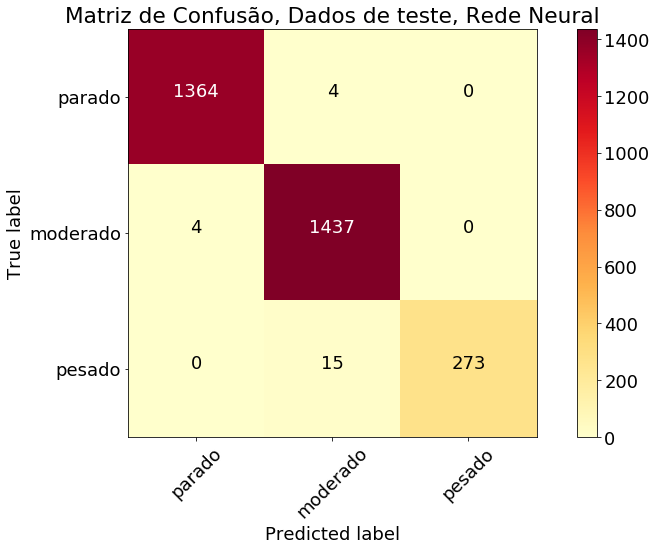

time: 307 ms


In [64]:
np.set_printoptions(precision=2)
cm = confusion_matrix(Y_test, 
                      y_pred)

plt.figure()
plot_confusion_matrix(cm, 
                      classes=["parado","moderado","pesado"],
                      title='Matriz de Confusão, Dados de teste, Rede Neural',
                        cmap='YlOrRd');
plt.savefig('../resources/conf_test.jpg')

# Evaluate held

In [65]:
Y_held = np.argmax(y_held, axis=1)
y_pred = model.predict_classes(X_held)
print(classification_report(Y_held, y_pred, target_names=["parado","moderado","pesado"]))

              precision    recall  f1-score   support

      parado       1.00      1.00      1.00      1011
    moderado       0.99      1.00      1.00      1055
      pesado       1.00      0.98      0.99       228

    accuracy                           1.00      2294
   macro avg       1.00      0.99      1.00      2294
weighted avg       1.00      1.00      1.00      2294

time: 184 ms


<Figure size 432x288 with 0 Axes>

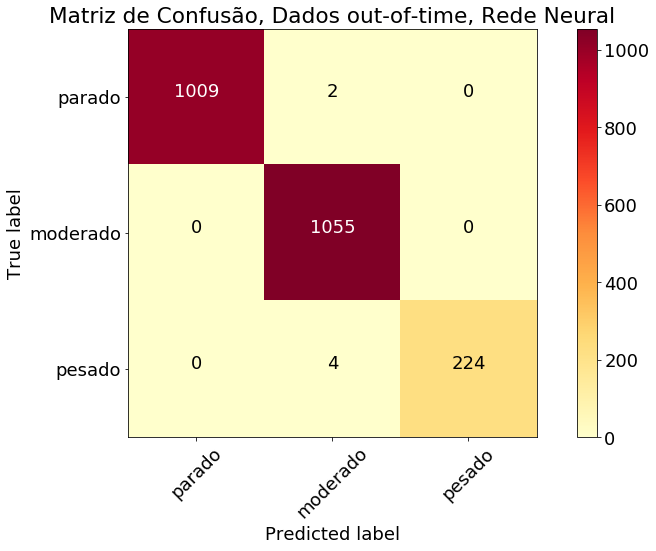

time: 217 ms


In [66]:
np.set_printoptions(precision=2)
cm = confusion_matrix(Y_held, 
                      y_pred)

plt.figure()
plot_confusion_matrix(cm, 
                      classes=["parado","moderado","pesado"],
                      title='Matriz de Confusão, Dados out-of-time, Rede Neural',
                      cmap='YlOrRd');
plt.savefig('../resources/conf_held.jpg')

# Save model

In [41]:
model.save("activity_detection.h5", include_optimizer=False)

time: 40 ms


In [44]:
tfjs.converters.save_keras_model(model, 'models')

time: 49 ms
